In [2]:
from network import * 
import math
from typing import Any
from training import *
import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import Module, init
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms

device = torch.device("cpu")


In [241]:
def plot_result(result_dict):
    losses = result_dict['losses']
    accuracies = result_dict['accuracies']
    models = result_dict['models']

    # Plotting
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    for m in models:
        n_trial = losses[m].shape[1]
        plt.plot(losses[m].mean(1), label=  m)
        plt.fill_between(np.arange(len(losses[m].mean(0))), losses[m].mean(0) - losses[m].std(0), 
                        losses[m].mean(0) + losses[m].std(0), alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Losses, n_trial = {}".format(n_trial))
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    for m in models:
        plt.plot(accuracies[m].mean(1), label= m)
        plt.fill_between(np.arange(len(accuracies[m].mean(0))), accuracies[m].mean(0) - accuracies[m].std(0), 
                        accuracies[m].mean(0) + accuracies[m].std(0), alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy, n_trial = {}".format(n_trial))
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1)
    plt.hist(model.parallel_synapse.ampli.data.cpu().numpy().flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,3,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,3,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')

    
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        labels = binary_labels(labels)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    plt.legend()
    plt.xlabel('hidden layer output')
    plt.ylabel('count')
    plt.title('Histogram, hidden layer output')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, hidden.data.cpu().numpy().flatten().max(), steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
    x = x - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = torch.tanh(x)
    x = x * ampli[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    plt.subplot(1,3,3)
    plt.plot(input[:,0].numpy(), x.detach().numpy())
    plt.xlabel('Input')
    plt.title('Aggregate synaptic output')
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.plot(model.theta.data.cpu().numpy()* np.ones((2,)), np.array(ylim), 'r-',  label='theta')
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer output')
    
    plt.tight_layout()
    plt.show()
    

# repeated trial:  5


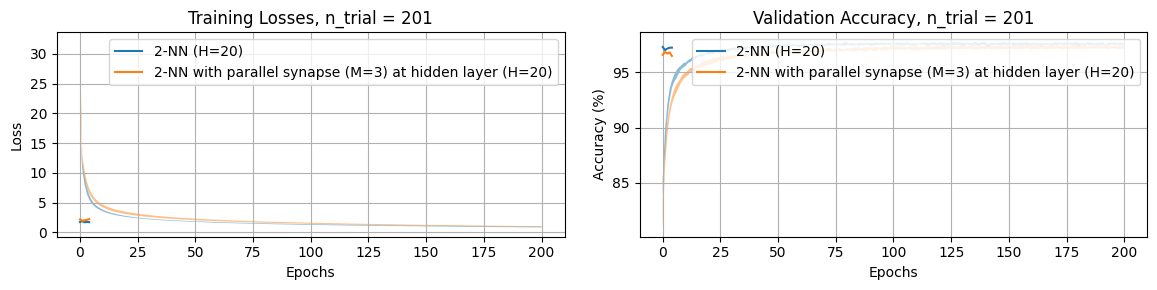

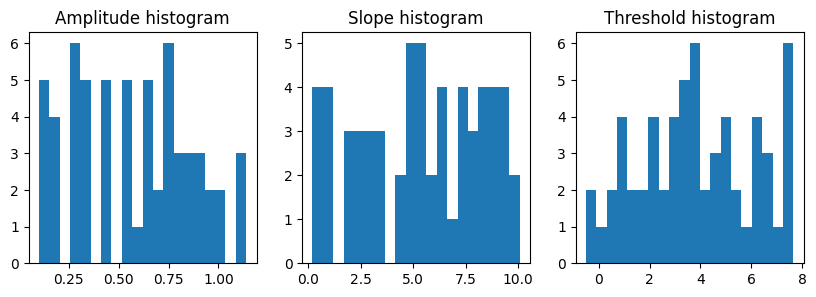

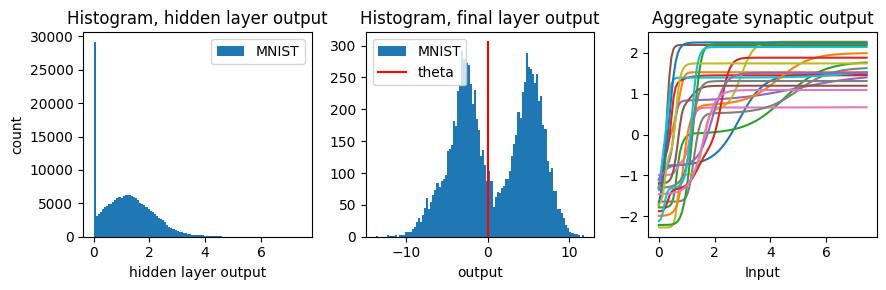

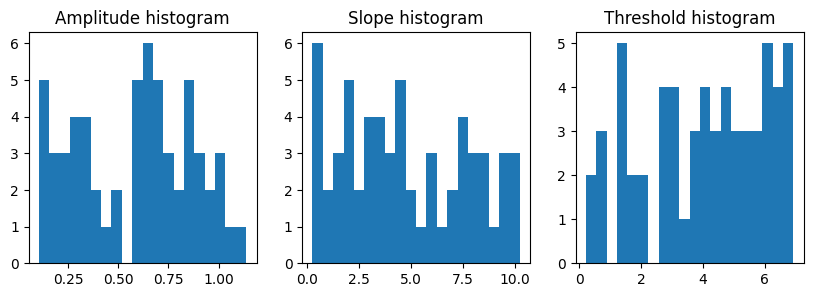

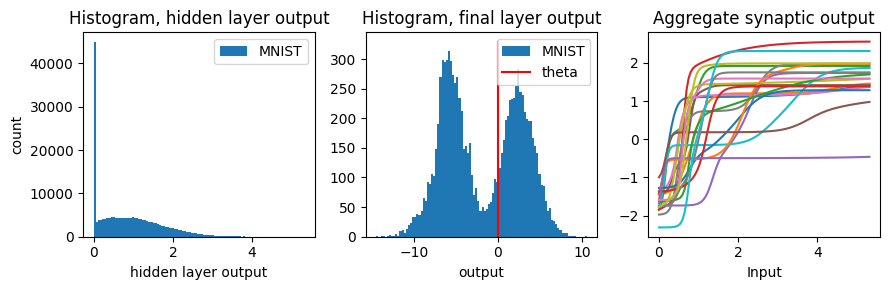

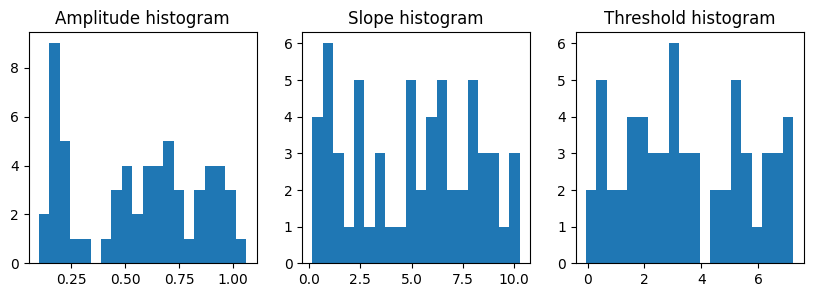

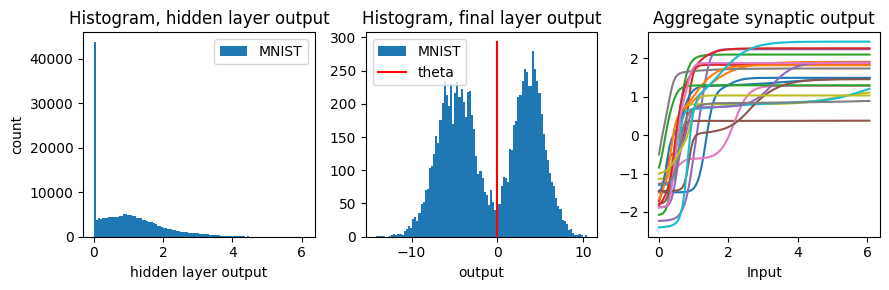

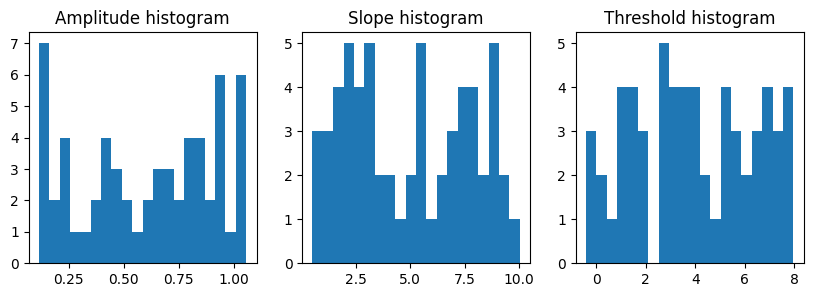

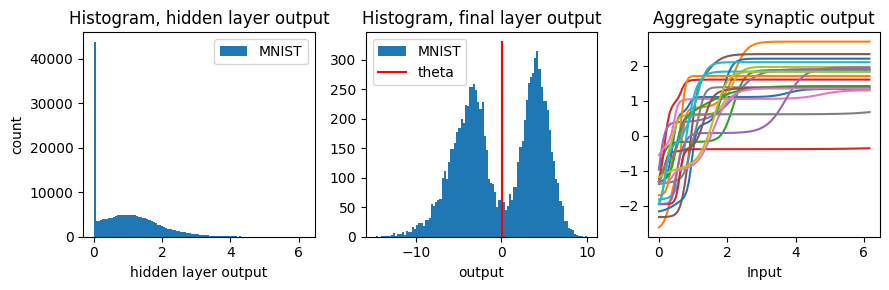

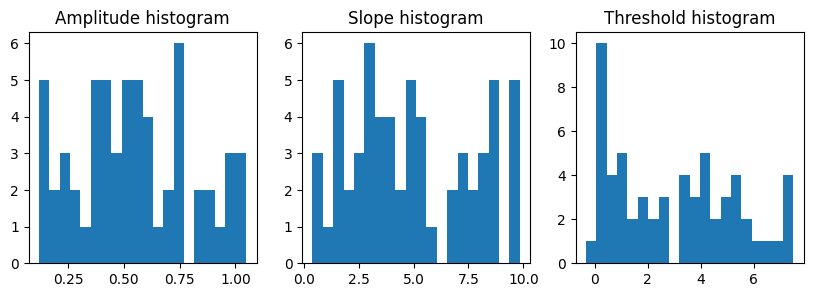

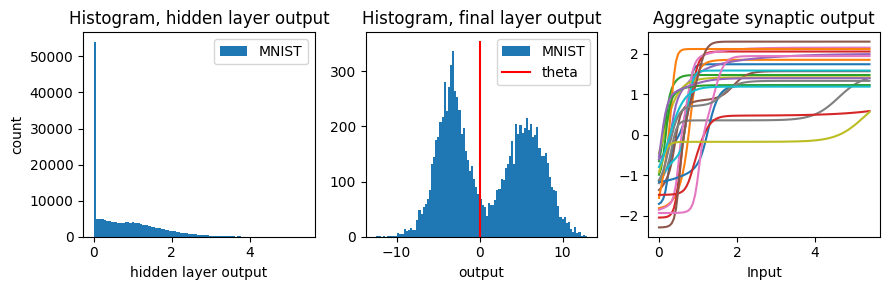

In [242]:
import pandas as pd
for H in [20]:
    
    df = pd.read_pickle('./data/MNIST_result_H={:d}_M=3_.pkl'.format(H))
    print('# repeated trial: ' , len(df))
    accuracies = {}
    losses = {}
    
    for model in df['models'][0].keys():
        accuracies[model] = np.array([df['accuracies'][i][model] for i in range(len(df))]).squeeze()
        losses[model] = np.array([df['losses'][i][model] for i in range(len(df))]).squeeze()
        
    plot_result({'losses': losses, 'accuracies': accuracies, 'models': df['models'][0].keys()})
    for model in df['models'][0].keys():
        if 'parallel synapse' in model:
            for i in range(len(df)):
                plot_parallel_synapse_params(df['models'][i][model])
                plot_input_histogram_to_parallel_synapse_layer(df['models'][i][model], hidden_act='relu')
            

In [254]:
print('2-NN (H=20)', accuracies['2-NN (H=20)'].mean(0)[-5:])
print('2-NN with parallel synapse (M=3) at hidden layer (H=20)',accuracies['2-NN with parallel synapse (M=3) at hidden layer (H=20)'].mean(0)[-5:])

2-NN (H=20) [97.584 97.518 97.556 97.528 97.534]
2-NN with parallel synapse (M=3) at hidden layer (H=20) [97.272 97.236 97.234 97.226 97.268]


Notations:
* dataset size: $P$
* input feature size: $N$
* parallel synapses per axon: $M$
* hidden layer size (if it's 2-layered neural network): $H$
* output dimension: $O$
* input $x$ has dimension: $[P, N]$

Input $x$ is $N = 28*28$ dimensional for MNIST.\
Layer 1 is fully connected layer with linear weight $w$ and sigmoid activation function $\sigma(x) = {1\over 1+ e^{-x}}$. This linear weight has shape $[H, N]$. 


Layer 2 is also fully connected layer, but the weight is calculated from aggregated parallel synapses. For this layer, there are $3 * H * M * O$ amount of parameters. If using $f_{ij}$ to denote element wise aggregate synaptic activaion funtion for $i$-th input dimension and $j$-th output dimension, parameterized by $M$ set of parallel synapses. Then the output layer receives:
$y = \sum_{i = 1}^H f_{ij}(h)$ for $j$-th output neuron.

Thus 